In [62]:
import numpy as np
from ILS_class import ILS
import matplotlib.pyplot as plt

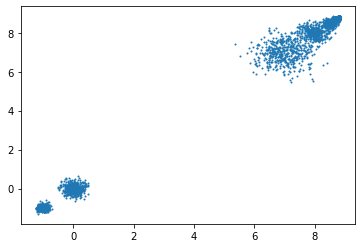

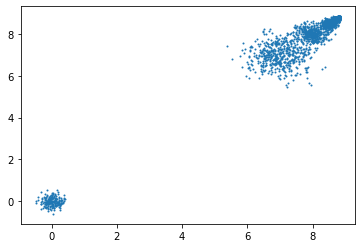

In [63]:
# create test data set

a = np.random.normal(-1, 0.1, (500, 2))
b = np.random.normal(0, 0.2, (500, 2))
c = np.random.normal(7, 0.5, (500, 2))
d = np.random.normal(8, 0.25, (400, 2))
e = np.random.normal(8.5, 0.1, (500, 2))
f = np.random.normal(8.7, 0.05, (800, 2))
g = np.random.normal(8.8, 0.02, (500, 2))

test_data = np.concatenate((a, b, c, d, e, f, g), axis = 0)
plt.scatter(test_data[:, 0], test_data[:, 1], s = 1)
plt.show()
plt.scatter(test_data[800:, 0], test_data[800:, 1], s = 1)
plt.show()

disconnected

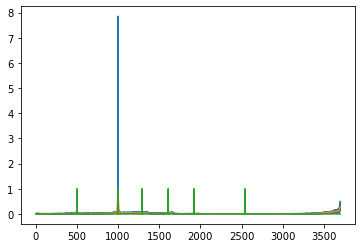

In [64]:
testILS = ILS(plot_rmin = True) # plots rmin and peaks found
testILS.fit(test_data)

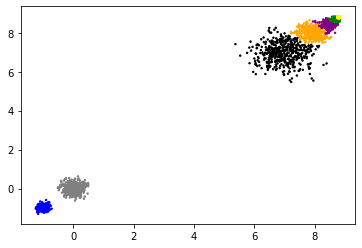

In [65]:
testILS.plot_labels()

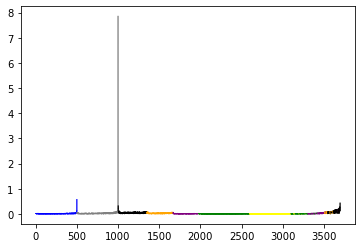

In [66]:
testILS.coloured_rmin()

Peak finding.
1. Identify points that are local maxima with respect to the minimum cluster size on each side
2. Calculate the mean and standard deviation on either side of the point. If the point exceeds the mean + 2.56 * standard deviation then the point  is considered a seperating peak
3. split rmin on these peaks
4. transform segmented Rmin series (discussed below)
5. identify local maxima on the transformed Rmin.
6. Calculate the peak prominence for each local maxima if it exceeds the sensitivity parameter add it as a peak. (default sensitivity is 0.1)
7. Split entire rmin on these identified peaks, find local minima within the segmentation

Rmin Transformation given below

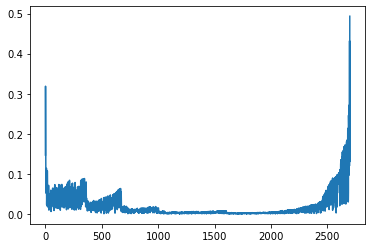

In [67]:
# plot rmin for the connected region
plt.plot(testILS.rmin[1000:])
plt.show()

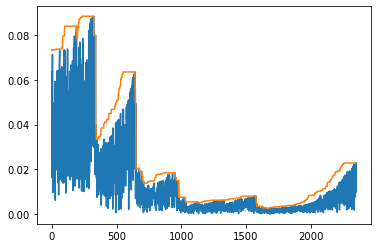

In [68]:
# First clip the end and beginning of the data set to remove the extremes

max_num_clusters = len(testILS.rmin[1000:])//testILS.min_cluster_size

new_rmin = testILS.rmin[1000 + testILS.min_cluster_size//8:-testILS.min_cluster_size * max_num_clusters // 8]
plt.plot(new_rmin)
new_rmin = testILS.moving_max(new_rmin, testILS.min_cluster_size//2)
plt.plot(new_rmin)
plt.show()

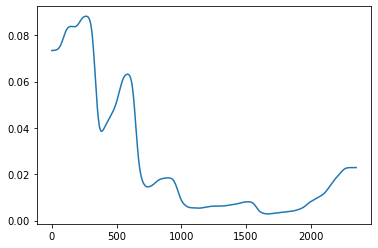

In [69]:
from scipy.ndimage import gaussian_filter1d

new_rmin = gaussian_filter1d(new_rmin, testILS.min_cluster_size//8) + 0.0000001
plt.plot(new_rmin)

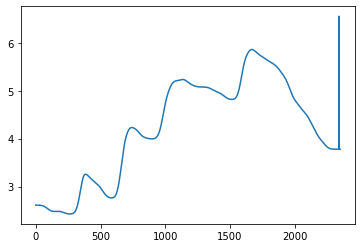

In [70]:
new_rmin[-10] = np.min(new_rmin)/2 # removing problem of extremely low densities by creating a point of lower density
new_rmin = -1 * np.log(new_rmin) # we take the log to identify transitions between clusters of high densities when there is a connected low density cluster
plt.plot(new_rmin)
plt.show()

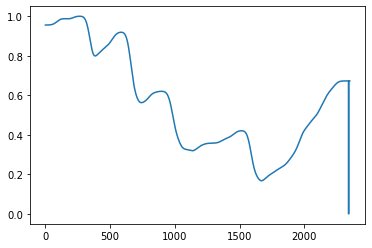

In [71]:
new_rmin = -1 * (new_rmin - np.min(new_rmin))/(np.max(new_rmin) - np.min(new_rmin))
new_rmin = new_rmin - np.min(new_rmin)
plt.plot(new_rmin)
plt.show()

Some assumptions:
 - ILS will traverse at least one eight of a cluster before moving to a cluster of lower density
 - clusters have a general center (hyperplane) where the density decrease as points move away from the center (this comes with any peak finding method)
 
Problems with this method
 - A possible segmentation split should be able to be identified regardless of the range of densities in the connected region (the rmin transformation does the opposite because of the log transform and adding the minimum)
 - will identify peaks within clusters significantly larger then the minimum cluster size.
 - often the smoothing is good enough to not require peak prominence and can just use any peak finding

Peak Prominence Calculation

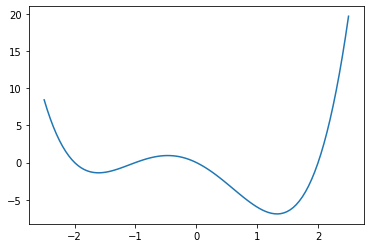

In [74]:
x = np.linspace(-2.5, 2.5, num = 100)
y = (x + 2) * (x + 1) * (x) * (x - 2)
plt.plot(x, y)
plt.show()

The peak prominence definition I used is defined as the difference between the height of the maximum and the height of the smallest point within the window. 

The window size is the the minimum of the minimum cluster size or the distance to next local maxima.